In [2]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import plotly.figure_factory as ff
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from keras.callbacks import TensorBoard
import datetime

In [2]:
%load_ext tensorboard

In [3]:
log_folder = 'logs'
%reload_ext tensorboard

In [4]:
import tensorboard
tensorboard.__version__

'2.10.1'

In [5]:
# Load the TensorBoard notebook extension
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard = TensorBoard(log_dir='./logs/model_1/' + current_time, histogram_freq=1, write_graph=True, write_images=True, update_freq='epoch', profile_batch=2)

2023-03-29 21:04:21.210527: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-29 21:04:21.210542: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-29 21:04:21.211276: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


In [5]:
df = pd.read_csv('../dataset/EA_dataset.csv')
dt = df['Date']
df.drop(columns='Date', inplace=True)
df.dropna(inplace=True)
df.isna().sum()

Close_Price               0
Volume                    0
Nasdaq_100                0
SP_500                    0
Ten_Year_Treasury_Rate    0
PE_Ratio                  0
Next_Day_Close_Price      0
DaysBeforeToday           0
PE_GIVEN_TAG              0
ROA                       0
GDP                       0
Day_Before_Next_Season    0
High_Price                0
Low_Price                 0
Open_Price                0
score                     0
Days_After_Last_News      0
dtype: int64

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, AveragePooling1D, Convolution2D, AveragePooling2D,TimeDistributed, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.optimizers import SGD

print(tf.__version__)

# Select the columns to be used as input features
features = ['Volume', 'Nasdaq_100', 'SP_500', 'Ten_Year_Treasury_Rate', 'DaysBeforeToday', 'ROA', 'GDP', 'Open_Price', 'score', 'Days_After_Last_News', 'High_Price', 'Low_Price', 'Close_Price', 'Open_Price',  'PE_Ratio', 'PE_GIVEN_TAG']

# Scale the input features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features].values)




2.10.0


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Next_Day_Close_Price'], test_size=0.2, shuffle=False)
X_train_series = np.array(X_train)
X_test_series = np.array(X_test)
print(X_test_series.shape)
print(X_train_series.shape)
subsequences = 2
timesteps = X_train_series.shape[1] // subsequences

(503, 16)
(2012, 16)


In [10]:
print(X_test_series.shape)
print(X_train_series.shape)

(503, 16)
(2012, 16)


In [29]:
print(X_test_series.shape)
print(X_train_series.shape)
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_test_series_sub.shape)

model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=4, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=4)))

model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(128, return_sequences=True ,activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(LSTM(256, return_sequences=False ,activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense(128, activation='relu'))

model_cnn_lstm.add(Dense(1, activation='relu'))
# Define the optimizer

model_cnn_lstm.compile(loss='mse', optimizer='Nadam', metrics=['mean_absolute_error'])
stop_early_1 = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', mode='min', patience=5)
# Fit the model to the training data
history = model_cnn_lstm.fit(X_train_series_sub, y_train, validation_data=(X_test_series_sub, y_test), epochs=140, batch_size=160, verbose=1, callbacks=[tensorboard])

'''
# Evaluate the model on the testing data
score = model_cnn_lstm.evaluate(X_train_series_sub, y_test, verbose=0)

# Print the evaluation score
print("Test score:", score)
'''

%tensorboard --logdir={log_folder}
# Make predictions on the testing data
y_pred = model_cnn_lstm.predict(X_test_series_sub)



(503, 16)
(2012, 16)
Train set shape (2012, 2, 8, 1)
Validation set shape (503, 2, 8, 1)
Epoch 1/140


2023-03-27 23:31:47.643012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/13 [=>............................] - ETA: 46s - loss: 3033.3342 - mean_absolute_error: 44.3510

2023-03-27 23:31:49.383922: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-27 23:31:49.383937: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


 3/13 [=====>........................] - ETA: 11s - loss: 3028.2239 - mean_absolute_error: 44.6893

2023-03-27 23:31:51.564462: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-27 23:31:51.570915: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-27 23:31:51.573946: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/model_1/20230327-230319/plugins/profile/2023_03_27_23_31_51

2023-03-27 23:31:51.577851: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/model_1/20230327-230319/plugins/profile/2023_03_27_23_31_51/tangyaodeMac-mini.local.trace.json.gz
2023-03-27 23:31:51.586578: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/model_1/20230327-230319/plugins/profile/2023_03_27_23_31_51

2023-03-27 23:31:51.588274: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/model_1/20230327-230319/plugins/pr

13/13 [==============================] - ETA: 0s - loss: 2888.2888 - mean_absolute_error: 43.5498

2023-03-27 23:31:53.241190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 8s 368ms/step - loss: 2888.2888 - mean_absolute_error: 43.5498 - val_loss: 11309.4062 - val_mean_absolute_error: 104.8975
Epoch 2/140
Epoch 2/140
13/13 [==============================] - 1s 83ms/step - loss: 1827.1667 - mean_absolute_error: 33.1461 - val_loss: 1332.0325 - val_mean_absolute_error: 31.7075
Epoch 3/140
13/13 [==============================] - 1s 76ms/step - loss: 863.9000 - mean_absolute_error: 25.5499 - val_loss: 1899.0907 - val_mean_absolute_error: 40.3457
Epoch 4/140
13/13 [==============================] - 1s 72ms/step - loss: 701.0891 - mean_absolute_error: 23.0395 - val_loss: 482.8819 - val_mean_absolute_error: 17.2503
Epoch 5/140
13/13 [==============================] - 1s 72ms/step - loss: 549.0269 - mean_absolute_error: 20.7612 - val_loss: 241.0025 - val_mean_absolute_error: 12.8024
Epoch 6/140
13/13 [==============================] - 1s 71ms/step - loss: 392.7907 - mean_absolute_error: 17.4281 - val_loss: 173.4992 - val_m

2023-03-27 23:33:55.599634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 29ms/step


In [30]:
y_pred = model_cnn_lstm.predict(X_test_series_sub)
y_pred.shape

16/16 [==============================] - 0s 13ms/step


(503, 1)

R2 score: 0.9483817222025968


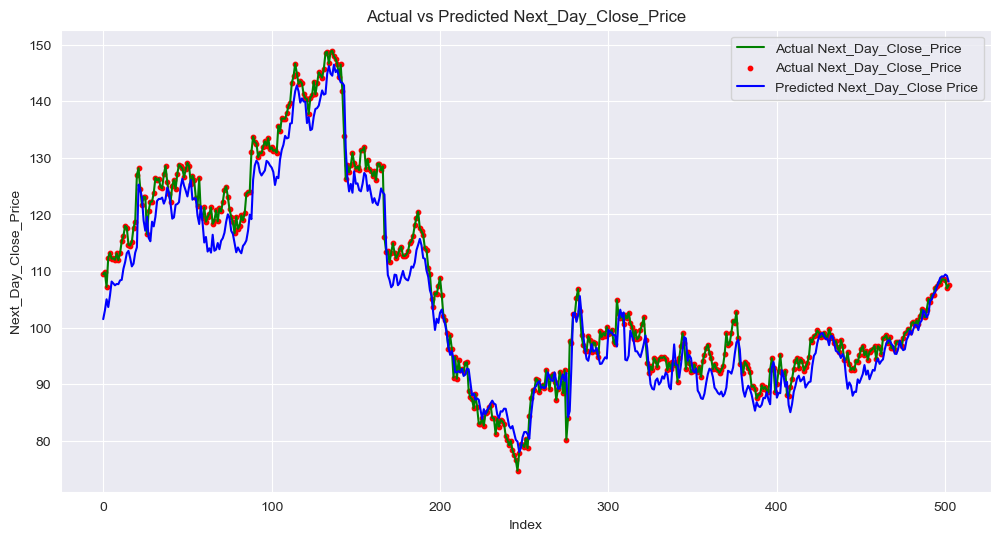

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)
import seaborn as sns

# Plotting the results
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
plt.plot(y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='green')
plt.scatter(y_test.reset_index(drop=True).index, y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='red', s=10)
plt.plot(y_pred, label='Predicted Next_Day_Close Price', color='blue')
plt.xlabel('Index')
plt.ylabel('Next_Day_Close_Price')
plt.legend()
plt.title('Actual vs Predicted Next_Day_Close_Price')
plt.show()
# batch size 200 - score 0.81 - maxpool - adam
# batch size 200 - score 0.79 - averagepool - adam
# batch size 200 - score 0.886 - averagepool - nadam
# add pe - average - 0.956 - average pool - nadam - 64 128 216 216

Test score: 0.7986949666234433


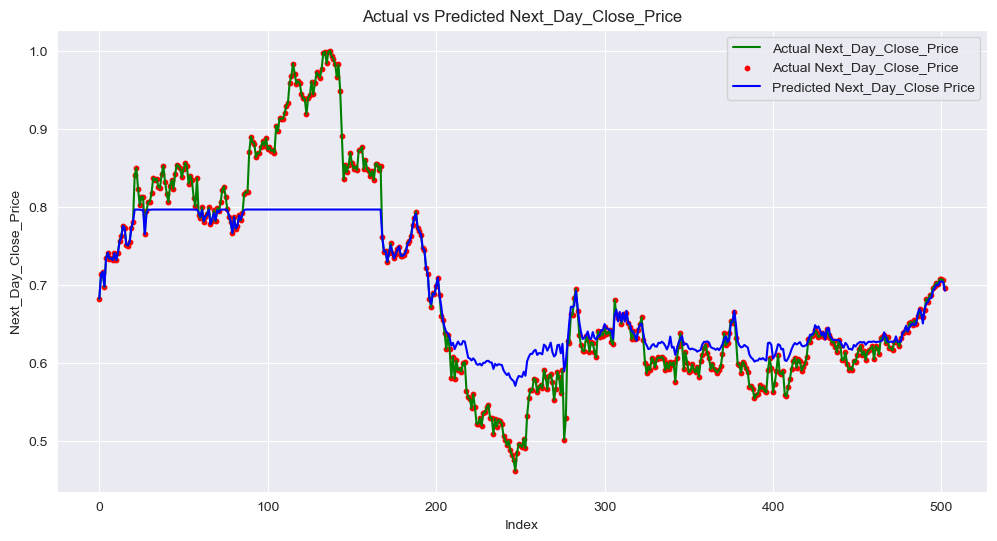

R2 score: 0.7986949666234433


In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# Select the columns to be used as input features
features = ['Volume', 'Nasdaq_100', 'SP_500', 'Ten_Year_Treasury_Rate', 'DaysBeforeToday', 'ROA', 'GDP', 'Open_Price', 'score', 'Days_After_Last_News', 'High_Price', 'Low_Price', 'Close_Price', 'Open_Price']

# Scale the input features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features].values)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Close_Price'], test_size=0.2, shuffle=False)

# Train the random forest model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Evaluate the model on the testing data
score = rf.score(X_test, y_test)

# Print the evaluation score
print("Test score:", score)

# Make predictions on the testing data
y_pred = rf.predict(X_test)

import seaborn as sns

# Plotting the results
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
plt.plot(y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='green')
plt.scatter(y_test.reset_index(drop=True).index, y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='red', s=10)
plt.plot(y_pred, label='Predicted Next_Day_Close Price', color='blue')
plt.xlabel('Index')
plt.ylabel('Next_Day_Close_Price')
plt.legend()
plt.title('Actual vs Predicted Next_Day_Close_Price')
plt.show()


# Calculate the R2 score
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score:", r2)

In [12]:
print(X_test_series.shape)
print(X_train_series.shape)
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_test_series_sub.shape)

model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(128, return_sequences=True ,activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(LSTM(256, return_sequences=False ,activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense(128, activation='relu'))

model_cnn_lstm.add(Dense(1, activation='relu'))
# Define the optimizer
sgd = SGD(learning_rate=0.01, momentum=0.9)
model_cnn_lstm.compile(loss='mse', optimizer='Nadam', metrics=['mean_absolute_error'])
stop_early_1 = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', mode='min', patience=5)
# Fit the model to the training data
history = model_cnn_lstm.fit(X_train_series_sub, y_train, validation_data=(X_test_series_sub, y_test), epochs=140, batch_size=160, verbose=1, callbacks=[tensorboard])

'''
# Evaluate the model on the testing data
score = model_cnn_lstm.evaluate(X_train_series_sub, y_test, verbose=0)

# Print the evaluation score
print("Test score:", score)
'''

%tensorboard --logdir={log_folder}
# Make predictions on the testing data
y_pred = model_cnn_lstm.predict(X_test_series_sub)

(503, 16)
(2012, 16)
Train set shape (2012, 2, 8, 1)
Validation set shape (503, 2, 8, 1)
Epoch 1/140


2023-03-29 21:07:28.911326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/13 [=>............................] - ETA: 34s - loss: 2957.6450 - mean_absolute_error: 44.0872

2023-03-29 21:07:30.353601: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-29 21:07:30.353614: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


 3/13 [=====>........................] - ETA: 13s - loss: 3051.9434 - mean_absolute_error: 45.3458

2023-03-29 21:07:32.951235: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-29 21:07:32.960343: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-29 21:07:32.966368: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/model_1/20230329-210421/plugins/profile/2023_03_29_21_07_32

2023-03-29 21:07:32.970454: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/model_1/20230329-210421/plugins/profile/2023_03_29_21_07_32/tangyaodeMac-mini.local.trace.json.gz
2023-03-29 21:07:32.981419: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/model_1/20230329-210421/plugins/profile/2023_03_29_21_07_32

2023-03-29 21:07:32.983076: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/model_1/20230329-210421/plugins/pr

13/13 [==============================] - ETA: 0s - loss: 2855.7344 - mean_absolute_error: 43.2094

2023-03-29 21:07:34.330726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 7s 378ms/step - loss: 2855.7344 - mean_absolute_error: 43.2094 - val_loss: 9380.3125 - val_mean_absolute_error: 95.2578
Epoch 2/140
Epoch 2/140
13/13 [==============================] - 1s 81ms/step - loss: 762.3965 - mean_absolute_error: 21.3491 - val_loss: 1134.6304 - val_mean_absolute_error: 26.6563
Epoch 3/140
13/13 [==============================] - 1s 74ms/step - loss: 262.5696 - mean_absolute_error: 14.1060 - val_loss: 2353.4871 - val_mean_absolute_error: 38.4784
Epoch 4/140
13/13 [==============================] - 1s 76ms/step - loss: 160.3232 - mean_absolute_error: 10.6153 - val_loss: 2849.4114 - val_mean_absolute_error: 42.6286
Epoch 5/140
13/13 [==============================] - 1s 77ms/step - loss: 103.1176 - mean_absolute_error: 8.0686 - val_loss: 4113.2759 - val_mean_absolute_error: 53.6314
Epoch 6/140
13/13 [==============================] - 1s 74ms/step - loss: 125.6783 - mean_absolute_error: 8.2675 - val_loss: 3294.9878 - val_mea

 1/16 [>.............................] - ETA: 5s

2023-03-29 21:09:40.660554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 21ms/step


16/16 [==============================] - 0s 12ms/step
R2 score: 0.9221030362930608


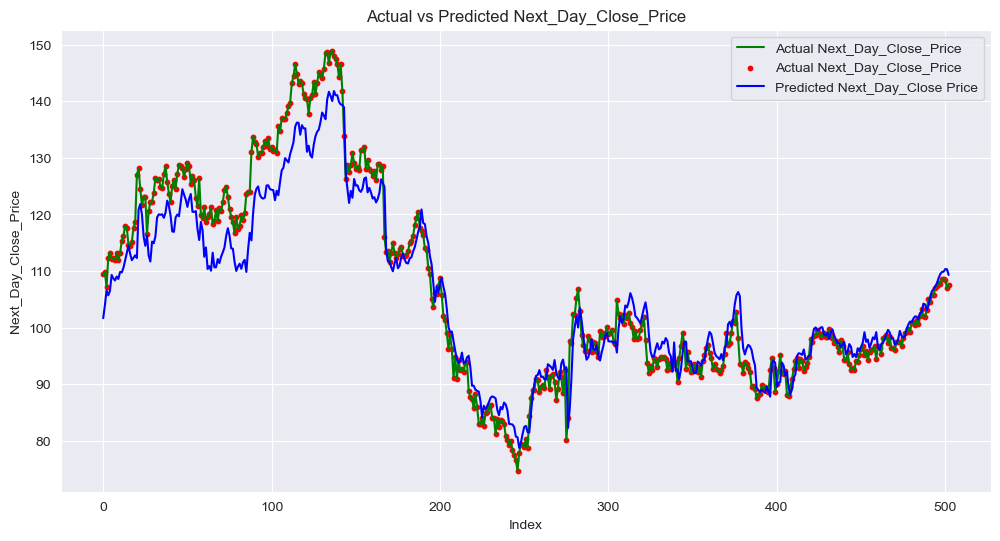

In [13]:
y_pred = model_cnn_lstm.predict(X_test_series_sub)
y_pred.shape
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)
import seaborn as sns

# Plotting the results
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
plt.plot(y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='green')
plt.scatter(y_test.reset_index(drop=True).index, y_test.reset_index(drop=True), label='Actual Next_Day_Close_Price', color='red', s=10)
plt.plot(y_pred, label='Predicted Next_Day_Close Price', color='blue')
plt.xlabel('Index')
plt.ylabel('Next_Day_Close_Price')
plt.legend()
plt.title('Actual vs Predicted Next_Day_Close_Price')
plt.show()
# batch size 200 - score 0.81 - maxpool - adam
# batch size 200 - score 0.79 - averagepool - adam
# batch size 200 - score 0.886 - averagepool - nadam
# add pe - average - 0.956 - average pool - nadam - 64 128 216 216

In [11]:
print(X_test_series.shape)
print(X_train_series.shape)
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_test_series_sub.shape)

(503, 16)
(2012, 16)
Train set shape (2012, 2, 8, 1)
Validation set shape (503, 2, 8, 1)


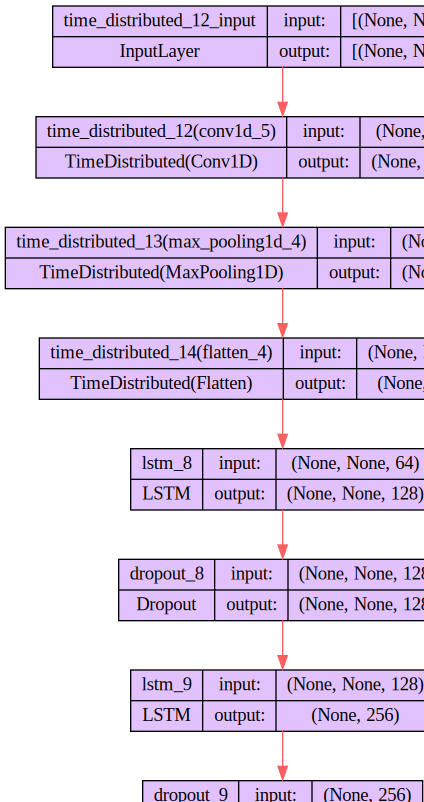

In [16]:
from tensorflow.keras.utils import plot_model
import pydot
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG, display
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=4, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=4)))

model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(128, return_sequences=True ,activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(LSTM(256, return_sequences=False ,activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense(128, activation='relu'))

model_cnn_lstm.add(Dense(1, activation='relu'))
# Define the optimizer

model_cnn_lstm.compile(loss='mse', optimizer='Nadam', metrics=['mean_absolute_error'])
dot = model_to_dot(model_cnn_lstm, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

# Customize the nodes and edges colors
for node in dot.get_nodes():
    node.set_fillcolor('#E1C2FF')
    node.set_style('filled')
    node.set_fontcolor('#000000')

for edge in dot.get_edges():
    edge.set_color('#FF5F5F')

# Save the graph to a file
dot.write_png('models/model_structure_fancy.png')

# Display the graph in Jupyter Notebook (optional)
display(SVG(dot.create_svg()))